# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [16]:
def generator(in_state, state_size=4, action_size=2, hidden_size=10, name='generator'):
    # state inputs to the Q-network2
    with tf.variable_scope(name): # for saving the generator weights and biases (model parameters)

        # ReLU hidden layers: generators
        fc1 = tf.contrib.layers.fully_connected(in_state, hidden_size)
        fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

        # Linear output layer
        logits = tf.contrib.layers.fully_connected(fc2, (state_size + action_size), 
                                                        activation_fn=None)

        # Split it into in and out
        logits_state_next, logits_action = tf.split(value=logits, num_or_size_splits=[state_size, action_size], 
                                               axis=1)

        # logits_action is for applying to the env or env.step and the predicted next state is for D
        return logits_state_next, logits_action

def discriminator(in_state_next, out_action, action_size=2, hidden_size=10, name='discriminator'):
    # state inputs to the Q-network2
    with tf.variable_scope(name):

        # one-hot encoding the actions: this can be the current give action or the predicted one for the current state
        out_action_onehot = tf.one_hot(out_action, action_size)

        # ### Train with loss (targetQ - Q)^2
        # # output has length 2, for two actions. This next line chooses
        # # one value from output (per row) according to the one-hot encoded actions.
        # self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
        # ReLU hidden layers: discriminator
        fused = tf.concat([in_state_next, out_action_onehot], axis)
        fc1 = tf.contrib.layers.fully_connected(fused, hidden_size)
        fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

        # Linear output layer
        logits = tf.contrib.layers.fully_connected(fc2, 1, activation_fn=None)

        # outputing the logit
        return logits

# # This GAN for iDRL
class Net:
    def __init__(self, state_size=4, learning_rate=0.01):
        # Current input states
        self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs') # NxCin

        # Current output action
        self.actions_ = tf.placeholder(tf.int32, [None], name='actions')

        # # Target Q values for training: next state
        # self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
        # Next input states
        self.inputs_next = tf.placeholder(tf.float32, [None, state_size], name='inputs_next') # NxCin
                
        # Linear output layer
        self.input_pred, self.output_pred = generator(self.inputs_)

        # D layer which is replacing the Q
        # State, reward, done and next_state is available
        # Qt is based on this state and action
        # MaxQt+1 is based on the next state
        # self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
        # Linear output layer
        d_logits_fake = self.discriminator(self.input_pred, self.output_pred)
        d_logits_real = self.discriminator(self.inputs_next, self.actions_)

        d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
                                                      logits=tf.zeros_like(d_logits_fake))
        d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_real, 
                                                      logits=tf.ones_like(d_logits_real))

        self.d_loss = d_loss_fake + d_loss_real
        self.g_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_logits_fake, 
                                                      logits=tf.ones_like(d_logits_fake))

        self.d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss)
        self.g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [8]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
train_episodes = 1          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [13]:
tf.reset_default_graph()
# mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
mainNet = Net()

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [14]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                # mainNet.generator(in_state= )
                feed = {mainNet.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 33.0 Training loss: 1.1065 Explore P: 0.9967
Episode: 2 Total reward: 11.0 Training loss: 1.1327 Explore P: 0.9957
Episode: 3 Total reward: 17.0 Training loss: 1.0435 Explore P: 0.9940
Episode: 4 Total reward: 32.0 Training loss: 1.0766 Explore P: 0.9908
Episode: 5 Total reward: 16.0 Training loss: 1.0618 Explore P: 0.9893
Episode: 6 Total reward: 16.0 Training loss: 1.1484 Explore P: 0.9877
Episode: 7 Total reward: 22.0 Training loss: 1.1627 Explore P: 0.9856
Episode: 8 Total reward: 19.0 Training loss: 1.0242 Explore P: 0.9837
Episode: 9 Total reward: 48.0 Training loss: 1.0352 Explore P: 0.9790
Episode: 10 Total reward: 21.0 Training loss: 1.1034 Explore P: 0.9770
Episode: 11 Total reward: 41.0 Training loss: 1.0110 Explore P: 0.9730
Episode: 12 Total reward: 33.0 Training loss: 0.9686 Explore P: 0.9699
Episode: 13 Total reward: 13.0 Training loss: 1.2567 Explore P: 0.9686
Episode: 14 Total reward: 11.0 Training loss: 1.1072 Explore P: 0.9676
Episode: 15 Tot

Episode: 116 Total reward: 11.0 Training loss: 147.7702 Explore P: 0.7850
Episode: 117 Total reward: 12.0 Training loss: 180.3980 Explore P: 0.7840
Episode: 118 Total reward: 23.0 Training loss: 100.0925 Explore P: 0.7822
Episode: 119 Total reward: 22.0 Training loss: 192.2653 Explore P: 0.7806
Episode: 120 Total reward: 16.0 Training loss: 206.6418 Explore P: 0.7793
Episode: 121 Total reward: 27.0 Training loss: 1836.8367 Explore P: 0.7772
Episode: 122 Total reward: 13.0 Training loss: 203.9281 Explore P: 0.7762
Episode: 123 Total reward: 8.0 Training loss: 194.8044 Explore P: 0.7756
Episode: 124 Total reward: 14.0 Training loss: 2093.6755 Explore P: 0.7746
Episode: 125 Total reward: 13.0 Training loss: 9891.9395 Explore P: 0.7736
Episode: 126 Total reward: 24.0 Training loss: 4291.8286 Explore P: 0.7717
Episode: 127 Total reward: 26.0 Training loss: 310.2965 Explore P: 0.7698
Episode: 128 Total reward: 21.0 Training loss: 453.5035 Explore P: 0.7682
Episode: 129 Total reward: 31.0 Tra

Episode: 229 Total reward: 26.0 Training loss: 6108.5146 Explore P: 0.6452
Episode: 230 Total reward: 45.0 Training loss: 207.5035 Explore P: 0.6424
Episode: 231 Total reward: 34.0 Training loss: 7187.6016 Explore P: 0.6402
Episode: 232 Total reward: 11.0 Training loss: 5801.0679 Explore P: 0.6395
Episode: 233 Total reward: 13.0 Training loss: 7334.1655 Explore P: 0.6387
Episode: 234 Total reward: 19.0 Training loss: 7564.9541 Explore P: 0.6375
Episode: 235 Total reward: 20.0 Training loss: 3649.0715 Explore P: 0.6363
Episode: 236 Total reward: 15.0 Training loss: 141.6954 Explore P: 0.6353
Episode: 237 Total reward: 16.0 Training loss: 269.1696 Explore P: 0.6343
Episode: 238 Total reward: 26.0 Training loss: 164.2867 Explore P: 0.6327
Episode: 239 Total reward: 15.0 Training loss: 70.4462 Explore P: 0.6318
Episode: 240 Total reward: 8.0 Training loss: 184.8210 Explore P: 0.6313
Episode: 241 Total reward: 11.0 Training loss: 7858.1768 Explore P: 0.6306
Episode: 242 Total reward: 18.0 T

Episode: 343 Total reward: 14.0 Training loss: 1680.7897 Explore P: 0.5388
Episode: 344 Total reward: 11.0 Training loss: 3487.0281 Explore P: 0.5382
Episode: 345 Total reward: 10.0 Training loss: 5257.2407 Explore P: 0.5377
Episode: 346 Total reward: 13.0 Training loss: 1373.0110 Explore P: 0.5370
Episode: 347 Total reward: 8.0 Training loss: 3943.8843 Explore P: 0.5366
Episode: 348 Total reward: 8.0 Training loss: 7488.3193 Explore P: 0.5362
Episode: 349 Total reward: 39.0 Training loss: 2285.1953 Explore P: 0.5341
Episode: 350 Total reward: 12.0 Training loss: 8725.9395 Explore P: 0.5335
Episode: 351 Total reward: 8.0 Training loss: 1245.1384 Explore P: 0.5331
Episode: 352 Total reward: 12.0 Training loss: 34.3467 Explore P: 0.5324
Episode: 353 Total reward: 30.0 Training loss: 52.6258 Explore P: 0.5309
Episode: 354 Total reward: 24.0 Training loss: 2543.4761 Explore P: 0.5296
Episode: 355 Total reward: 10.0 Training loss: 1133.1891 Explore P: 0.5291
Episode: 356 Total reward: 12.0 

Episode: 456 Total reward: 11.0 Training loss: 47.2658 Explore P: 0.4630
Episode: 457 Total reward: 13.0 Training loss: 80.1152 Explore P: 0.4624
Episode: 458 Total reward: 14.0 Training loss: 63.9183 Explore P: 0.4618
Episode: 459 Total reward: 8.0 Training loss: 641.6522 Explore P: 0.4614
Episode: 460 Total reward: 11.0 Training loss: 55.0222 Explore P: 0.4609
Episode: 461 Total reward: 12.0 Training loss: 692.1355 Explore P: 0.4604
Episode: 462 Total reward: 16.0 Training loss: 1372.9890 Explore P: 0.4597
Episode: 463 Total reward: 16.0 Training loss: 6373.0576 Explore P: 0.4589
Episode: 464 Total reward: 11.0 Training loss: 765.8184 Explore P: 0.4585
Episode: 465 Total reward: 10.0 Training loss: 50.9289 Explore P: 0.4580
Episode: 466 Total reward: 9.0 Training loss: 9009.0771 Explore P: 0.4576
Episode: 467 Total reward: 27.0 Training loss: 4131.6304 Explore P: 0.4564
Episode: 468 Total reward: 11.0 Training loss: 4438.8374 Explore P: 0.4559
Episode: 469 Total reward: 15.0 Training

Episode: 568 Total reward: 37.0 Training loss: 1640.1973 Explore P: 0.4026
Episode: 569 Total reward: 8.0 Training loss: 459.2193 Explore P: 0.4023
Episode: 570 Total reward: 11.0 Training loss: 32.4012 Explore P: 0.4019
Episode: 571 Total reward: 15.0 Training loss: 15.7514 Explore P: 0.4013
Episode: 572 Total reward: 11.0 Training loss: 603.2990 Explore P: 0.4008
Episode: 573 Total reward: 8.0 Training loss: 15.6078 Explore P: 0.4005
Episode: 574 Total reward: 7.0 Training loss: 20.0159 Explore P: 0.4003
Episode: 575 Total reward: 15.0 Training loss: 339.7573 Explore P: 0.3997
Episode: 576 Total reward: 11.0 Training loss: 1922.6272 Explore P: 0.3992
Episode: 577 Total reward: 11.0 Training loss: 18.1155 Explore P: 0.3988
Episode: 578 Total reward: 8.0 Training loss: 1878.0784 Explore P: 0.3985
Episode: 579 Total reward: 10.0 Training loss: 15.7114 Explore P: 0.3981
Episode: 580 Total reward: 12.0 Training loss: 3331.7820 Explore P: 0.3977
Episode: 581 Total reward: 11.0 Training los

Episode: 681 Total reward: 18.0 Training loss: 7.2255 Explore P: 0.3509
Episode: 682 Total reward: 7.0 Training loss: 106.9722 Explore P: 0.3506
Episode: 683 Total reward: 18.0 Training loss: 15.1347 Explore P: 0.3500
Episode: 684 Total reward: 8.0 Training loss: 12.8887 Explore P: 0.3497
Episode: 685 Total reward: 21.0 Training loss: 6.1163 Explore P: 0.3490
Episode: 686 Total reward: 15.0 Training loss: 169.7453 Explore P: 0.3485
Episode: 687 Total reward: 10.0 Training loss: 8.3663 Explore P: 0.3482
Episode: 688 Total reward: 10.0 Training loss: 143.8913 Explore P: 0.3479
Episode: 689 Total reward: 10.0 Training loss: 6.9835 Explore P: 0.3475
Episode: 690 Total reward: 17.0 Training loss: 201.7145 Explore P: 0.3469
Episode: 691 Total reward: 14.0 Training loss: 9.5257 Explore P: 0.3465
Episode: 692 Total reward: 11.0 Training loss: 5.0485 Explore P: 0.3461
Episode: 693 Total reward: 12.0 Training loss: 937.0554 Explore P: 0.3457
Episode: 694 Total reward: 15.0 Training loss: 5.0816 

Episode: 794 Total reward: 11.0 Training loss: 2.9084 Explore P: 0.3074
Episode: 795 Total reward: 10.0 Training loss: 5.5826 Explore P: 0.3071
Episode: 796 Total reward: 13.0 Training loss: 351.5965 Explore P: 0.3067
Episode: 797 Total reward: 21.0 Training loss: 174.7556 Explore P: 0.3061
Episode: 798 Total reward: 11.0 Training loss: 147.2973 Explore P: 0.3058
Episode: 799 Total reward: 14.0 Training loss: 154.4129 Explore P: 0.3054
Episode: 800 Total reward: 13.0 Training loss: 66.7986 Explore P: 0.3050
Episode: 801 Total reward: 10.0 Training loss: 284.6322 Explore P: 0.3047
Episode: 802 Total reward: 20.0 Training loss: 5.5575 Explore P: 0.3041
Episode: 803 Total reward: 21.0 Training loss: 501.8349 Explore P: 0.3035
Episode: 804 Total reward: 19.0 Training loss: 240.1639 Explore P: 0.3029
Episode: 805 Total reward: 14.0 Training loss: 78.6106 Explore P: 0.3025
Episode: 806 Total reward: 9.0 Training loss: 3.3344 Explore P: 0.3022
Episode: 807 Total reward: 14.0 Training loss: 16

Episode: 909 Total reward: 11.0 Training loss: 315.7150 Explore P: 0.2690
Episode: 910 Total reward: 13.0 Training loss: 63.1344 Explore P: 0.2687
Episode: 911 Total reward: 10.0 Training loss: 88.0061 Explore P: 0.2685
Episode: 912 Total reward: 12.0 Training loss: 0.5990 Explore P: 0.2681
Episode: 913 Total reward: 12.0 Training loss: 1.4299 Explore P: 0.2678
Episode: 914 Total reward: 8.0 Training loss: 121.3418 Explore P: 0.2676
Episode: 915 Total reward: 14.0 Training loss: 79.9609 Explore P: 0.2673
Episode: 916 Total reward: 11.0 Training loss: 98.8076 Explore P: 0.2670
Episode: 917 Total reward: 11.0 Training loss: 77.5317 Explore P: 0.2667
Episode: 918 Total reward: 15.0 Training loss: 190.4252 Explore P: 0.2663
Episode: 919 Total reward: 11.0 Training loss: 82.3076 Explore P: 0.2660
Episode: 920 Total reward: 24.0 Training loss: 0.9878 Explore P: 0.2654
Episode: 921 Total reward: 26.0 Training loss: 223.6888 Explore P: 0.2648
Episode: 922 Total reward: 19.0 Training loss: 36.4

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

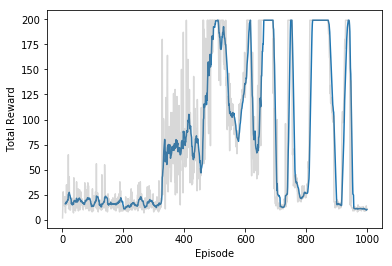

In [14]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [14]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [15]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.